In [1]:
%reset -f
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Lets import some useful packages

In [2]:
import warnings
warnings.filterwarnings("ignore")
import random
from copy import deepcopy as dp

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, TensorBoard
from keras.initializers import RandomNormal as RN
from keras.utils.vis_utils import model_to_dot



from utils import *


from tqdm import *
import os 
from os import system
from PIL import Image
from IPython.display import SVG
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score

Using TensorFlow backend.


## Some parameters

In [3]:
size = 128
data_train_path_target = "data_airbus_defi/train/"
data_test_path = "data_airbus_defi/test/"
input_shape = (size, size, 3)

## Loading data. Numpy arrays

In [4]:
XTRAIN, train_label1, x_test = loadDATA(PATH=os.getcwd(),full=False, some=True, little=2000)
system('say Data chargée!')
print("Data chargée!")
print("Input data shape : ")
print(XTRAIN.shape)

Data chargée!
Input data shape : 
(10002, 128, 128, 3)


## Suffling data
Not (totally) sure it is useful. As Keras might do it itself

Quite long when we use every data

In [5]:
XTRAIN, train_labels = unison_shuffled_copies(XTRAIN,train_label1)
system('say Data mélangée!')
print("Data mélangée!")

Data mélangée!


## Model generator

In [6]:
def cnn(n_layers, MIN_NEURONS=12, MAX_NEURONS=32, KERNEL=(3,3), dropout=.4):
    global input_shape
    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    model = Sequential()
    for i in range(0, n_layers):
        if i == 0:
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=input_shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [8]:
modelCNN = cnn(1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 12)      336       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 12)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 47628)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1524128   
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
__________

## The model. Finally !

In [9]:
trained = False

epochs = 5
validation_split = .1
conv2Dsize = 32
pool_size = (3,3)
fulSize = 16
dropout = .5

if not trained:
    modelBW = Sequential()
    modelBW.add(Conv2D(conv2Dsize, (4,4), input_shape = input_shape, activation = 'relu'))
    modelBW.add(Conv2D(12, pool_size, activation = 'relu'))
    modelBW.add(Conv2D( 6, (2,2), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = (2,2)))
    modelBW.add(Dropout(dropout))
    modelBW.add(Conv2D(conv2Dsize, (3, 3), activation = 'relu'))
    modelBW.add(MaxPooling2D(pool_size = pool_size))
    modelBW.add(Dropout(dropout))
    modelBW.add(Flatten())
    modelBW.add(Dense(units = fulSize, activation = 'sigmoid'))
    modelBW.add(Dense(units = 1, activation = 'sigmoid'))

    modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    modelBW.summary()
else:
    modelBW = loadModel("2018-11-06 13:52")
    modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    modelBW.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 125, 125, 32)      1568      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 123, 12)      3468      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 122, 122, 6)       294       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 6)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 61, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 59, 32)        1760      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 32)        0         
__________

## Learning

In [9]:
shufflingTimes = 5
epochs = 5
validation_split = .5
for i in range(shufflingTimes):
    history = modelCNN.fit(XTRAIN, train_labels, epochs=epochs, verbose=1, validation_split=validation_split, batch_size=32)
    if i < shufflingTimes - 1:
        XTRAIN, train_labels = unison_shuffled_copies(XTRAIN,train_labels)

Train on 5001 samples, validate on 5001 samples
Epoch 1/5
5001/5001 [==============================] - 51s 10ms/step - loss: 0.5473 - acc: 0.7500 - val_loss: 0.3662 - val_acc: 0.8714
Epoch 2/5
5001/5001 [==============================] - 42s 8ms/step - loss: 0.3345 - acc: 0.8728 - val_loss: 0.4580 - val_acc: 0.7844
Epoch 3/5
5001/5001 [==============================] - 42s 8ms/step - loss: 0.2970 - acc: 0.8890 - val_loss: 0.2923 - val_acc: 0.8932
Epoch 4/5
5001/5001 [==============================] - 43s 9ms/step - loss: 0.2483 - acc: 0.9088 - val_loss: 0.2959 - val_acc: 0.8950
Epoch 5/5
5001/5001 [==============================] - 41s 8ms/step - loss: 0.2402 - acc: 0.9066 - val_loss: 0.2987 - val_acc: 0.8946
Train on 5001 samples, validate on 5001 samples
Epoch 1/5
5001/5001 [==============================] - 64s 13ms/step - loss: 0.2469 - acc: 0.9078 - val_loss: 0.2590 - val_acc: 0.8970
Epoch 2/5
5001/5001 [==============================] - 46s 9ms/step - loss: 0.2202 - acc: 0.9190 -

KeyboardInterrupt: 

In [193]:
history = modelBW.fit(XTRAIN, train_labels, epochs=epochs, verbose=1, validation_split=validation_split, batch_size=16)

Train on 9001 samples, validate on 1001 samples
Epoch 1/5
9001/9001 [==============================] - 337s 37ms/step - loss: 0.3444 - acc: 0.8677 - val_loss: 0.2778 - val_acc: 0.8921
Epoch 2/5
9001/9001 [==============================] - 310s 34ms/step - loss: 0.2522 - acc: 0.9037 - val_loss: 0.2799 - val_acc: 0.8871
Epoch 3/5
9001/9001 [==============================] - 302s 34ms/step - loss: 0.2232 - acc: 0.9146 - val_loss: 0.2102 - val_acc: 0.9161
Epoch 4/5
9001/9001 [==============================] - 60637s 7s/step - loss: 0.2022 - acc: 0.9250 - val_loss: 0.2104 - val_acc: 0.9171
Epoch 5/5
9001/9001 [==============================] - 436s 48ms/step - loss: 0.1903 - acc: 0.9287 - val_loss: 0.2058 - val_acc: 0.9291


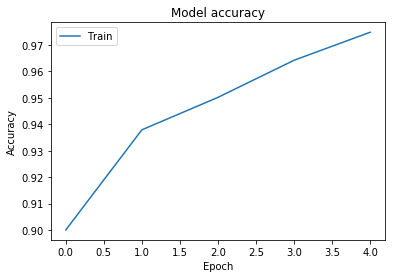

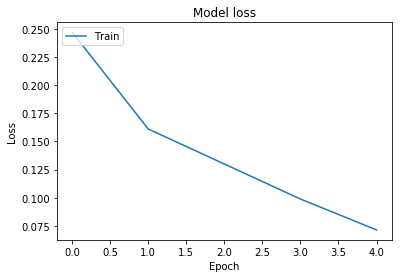

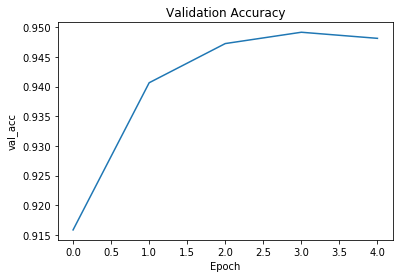

In [10]:
plotLearning(history)

## Prediction

In [32]:
predictions = prediction_from_model(modelCNN,x_test)
prediction = predictions[0]
predictionProba = predictions[1]

some predictions
[1, 0, 0, 0, 1, 1, 0, 1, 1]


## Writting output

In [11]:
from utils import soumissionCSV

In [12]:
today = str(datetime.today())[:16]
soumissionCSV(prediction, today,PATH=os.getcwd())

e
CSV file written


In [13]:
system('say On est bon!')

0

In [14]:
print("Proportion of windmills")
sum(prediction)/ len(prediction)

Proportion of windmills


0.44582551594746717

In [16]:
saveModel(modelCNN, today)

Saved model


## Improving model

In [37]:
[1,2,3,4,5,6][:2]

[1, 2]

In [81]:
def probaErrors(XTRAIN,model,size=1000):
    Xviz = XTRAIN[:size]
    lab = train_labels[:size]
    p = model.predict(Xviz)
    pr = [cut_half(x) for x in p]
    probas = []
    
    for reel, devine, proba in zip(lab,pr,p):
        if reel != devine:
            probas.append(proba)
    return [val[0] for val in probas], [pp[0] for pp in p]
probaEnquete, probas = probaErrors(XTRAIN, modelCNN, 2000)

In [82]:
probas[0]

0.99970955

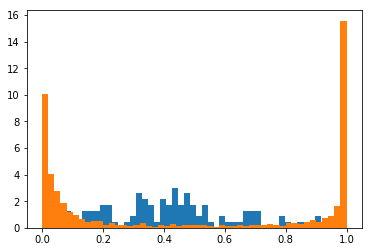

In [90]:
plt.hist(probaEnquete, normed=True, bins=50)
plt.hist(probas, normed=True, bins=50)
plt.show()
plt.close()

In [91]:
def visualizeUncertainLabels(x_test,probaPred,threshold):
    i=0
    X = []
    ps = []
    for proba in probaPred:
        if abs(0.5 - proba) < threshold:
            X.append(Xviz[i])
            ps.append(proba)
        i+=1
        if i > 100:
            break
    
    x_data = np.array(X)
    count = 0
    #x_data = x_data[incorrect_label_indices, :, :, :]
    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))
    figure = plt.figure(figsize=((maximum_square * 2,maximum_square * 2)))

    for j in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[j, :, :, :])
        plt.axis('off')
        plt.title(" Real: " + str(ps[j]), fontsize=10)

    plt.show()

0

In [92]:
visualizeUncertainLabels(x_test, predictionProba,.1)

TypeError: 'int' object is not iterable

In [68]:
def visualize_incorrect_labels(x_data, y_real):
    count = 0
    
    #x_data = x_data[incorrect_label_indices, :, :, :]
    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))
    figure = plt.figure(figsize=((maximum_square * 2,maximum_square * 2)))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title(" Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

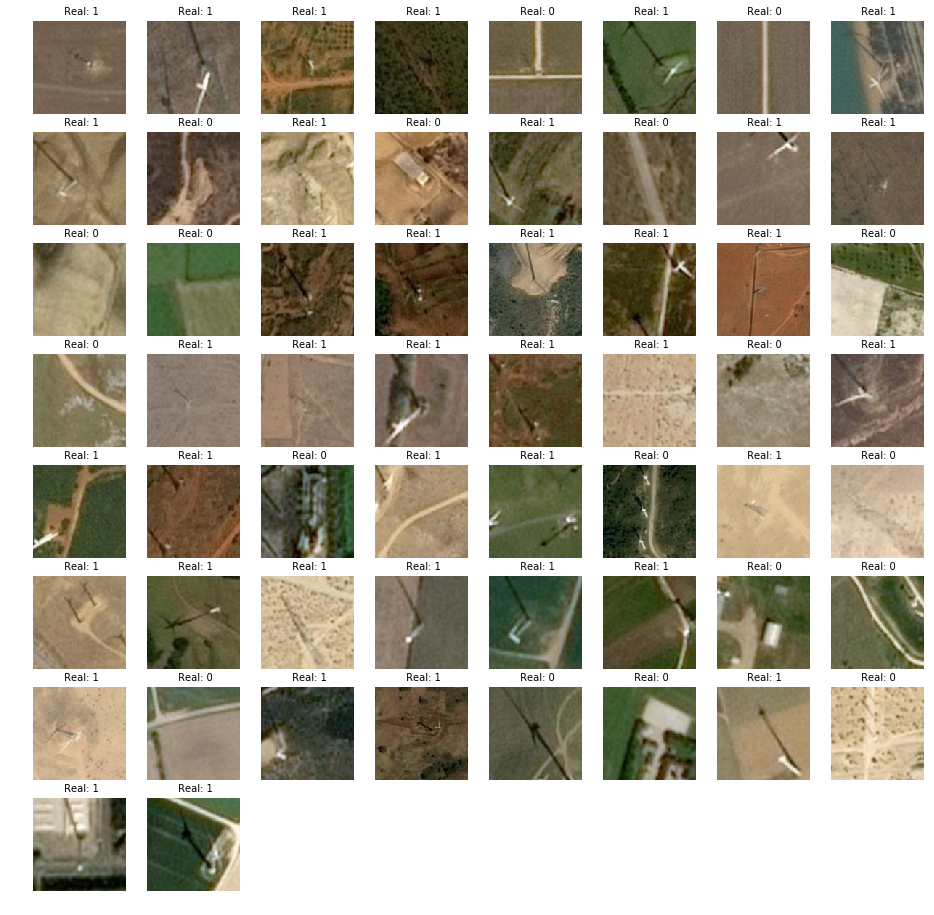

In [51]:
visualize_incorrect_labels(Xvizu, labs)

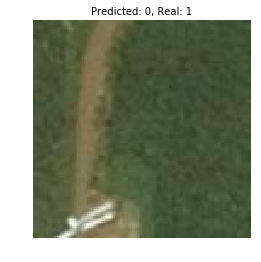

In [34]:
visualize_incorrect_labels(Xviz, lab, np.array(pr))

---------

## Loading old models

In [28]:
loadedModel = loadModel("2018-11-06 13:52")
pred, predProba = prediction_from_model(loadedModel,x_test)


Loaded model from disk
some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]


-------

In [30]:
pred = modelCNN.predict(x_test)

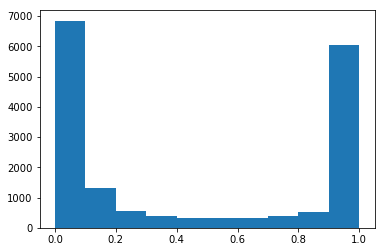

In [31]:
plt.hist(pred)
plt.show()
plt.close()

## One model that was good

In [ ]:
epochs = 50
validation_split = .1
conv2Dsize = 12
pool_size = (2,2)


modelBW = Sequential()
modelBW.add(Conv2D(conv2Dsize, (5), 
                  padding="same", 
                  input_shape=input_shape))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

# second set of CONV => RELU => POOL layers
modelBW.add(Conv2D(conv2Dsize, (5, 5), padding="same"))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
#model.add(Dropout(0.2)) ???



#first (and only) set of FC => RELU layers
modelBW.add(Flatten())
modelBW.add(Dense(2))
modelBW.add(Activation("sigmoid"))

# softmax classifier
modelBW.add(Dense(1))
modelBW.add(Activation("relu"))
modelBW.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])

